# Lab 2. Recomendation Systems
---
#### by Sapozhnikov Andrey

In [2]:
! cp ./drive/MyDrive/archive\ \(1\).zip ./archive.zip
! unzip ./archive.zip

Archive:  ./archive.zip
  inflating: anime.csv               
  inflating: rating.csv              


In [87]:
import pandas as pd
import numpy  as np
import seaborn as sns
import random
import matplotlib.pyplot as plt

In [4]:
anime_df = pd.read_csv("anime.csv")
print(f"Data size: {len(anime_df)}")
anime_df.head()

Data size: 12294


,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [5]:
rating_df = pd.read_csv("rating.csv")
print(f"Data size: {len(rating_df)}")
rating_df.head()

Data size: 7813737


,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [6]:
len(rating_df.user_id.unique())

73515

In [7]:
len(rating_df.anime_id.unique())

11200

## Sampling

Возьму только 10% от укниальных пользователей и аниме для уменьшения размера матрицы пересечений и ускорения вычислений


In [8]:
users_unique = rating_df.user_id.unique()
anime_unique = rating_df.anime_id.unique()

Сделаю рандомную выборку отдельно по id юзеров и id аниме  

---

*(По моему опыту это увеличило Sparsity по сравнению с выбором первых N объектов на 12%)*

In [9]:
part = 0.1
sample_users_ids_size = int(len(rating_df.user_id.unique()) * part)
sample_anime_ids_size = int(len(rating_df.anime_id.unique()) * part)

sampled_user_ids = rating_df['user_id'].sample(sample_users_ids_size)
sample_anime_ids = rating_df['anime_id'].sample(sample_anime_ids_size)

rating_df = rating_df[(rating_df['user_id'].isin(sampled_user_ids)) & 
                      (rating_df['anime_id'].isin(sample_anime_ids)) ]
print("Data size: ", len(rating_df))
rating_df.head()

Data size:  739460


,user_id,anime_id,rating
1170,11,30,5
1171,11,43,7
1172,11,44,7
1174,11,59,7
1175,11,61,4


In [10]:
len(rating_df.user_id.unique()), sample_users_ids_size

(6474, 7351)

In [11]:
len(rating_df.anime_id.unique()), sample_anime_ids_size

(772, 1120)

* Небольшая часть выбранных юзеров оказалась без рейтингов (их оцененное аниме не вошло в выборку)
* Небольшая часть выбранных аниме оказалась без рейтингов (оценившие их юзеры не вошли в выборку)

## Task1

### Распределение числа пользователей по количеству взаимодействий

In [168]:
plt.rcParams['figure.dpi'] = 70

In [169]:
rating_df.user_id.value_counts().value_counts()
# number of iteractions - unique users

50     51
53     48
60     47
90     47
57     47
       ..
372     1
371     1
370     1
363     1
767     1
Name: user_id, Length: 418, dtype: int64

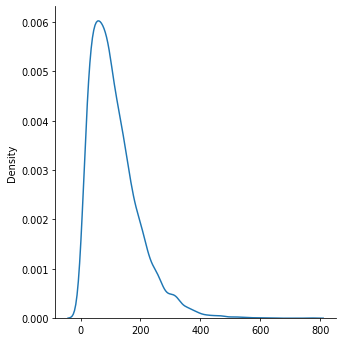

In [170]:
data = rating_df.user_id.value_counts().values
sns.displot(data, kind="kde")
plt.show()

### Разпределение числа "айтемов" по количеству взаимодействий

In [171]:
rating_df.anime_id.value_counts().value_counts()
# number of iteractions - unique animes

251     4
207     3
1030    3
297     3
248     3
       ..
1175    1
1174    1
1171    1
1164    1
2       1
Name: anime_id, Length: 653, dtype: int64

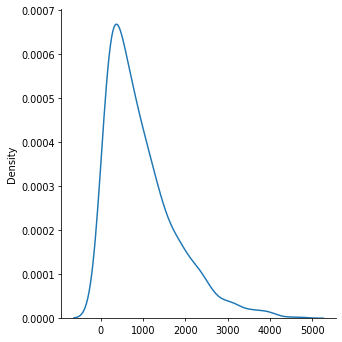

In [172]:
data = rating_df.anime_id.value_counts().values
sns.displot(data, kind="kde")
plt.show()

### Распределение числа рейтингов, средних рейтингов по пользователям, по "айтемам"

* распределение числа рейтингов по пользователям

In [173]:
rating_df.groupby('user_id').rating.nunique()
# unique user - unique ratings in user

user_id
11        8
17        9
21        8
62        5
64        3
         ..
73476    11
73480     6
73495     7
73502     9
73504     6
Name: rating, Length: 6474, dtype: int64

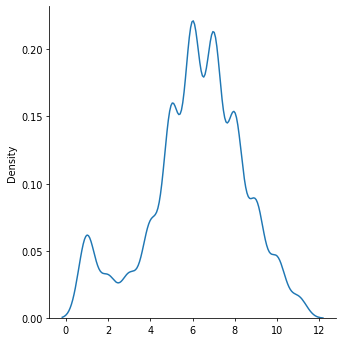

In [174]:
data = rating_df.groupby('user_id').rating.nunique().values
sns.displot(data, kind="kde")
plt.show()

* распределение числа рейтингов по айтемам

In [175]:
rating_df.groupby('anime_id').rating.nunique()
# unique anime - unique ratings in user

anime_id
1        11
5        10
6         9
18        8
20       11
         ..
32915     7
32998     8
33201     9
33421     9
33979     7
Name: rating, Length: 772, dtype: int64

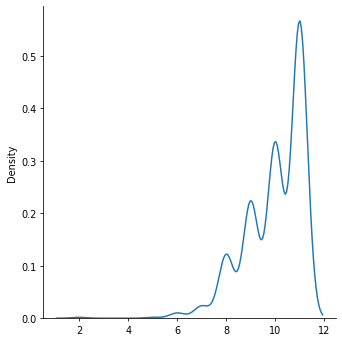

In [176]:
data = rating_df.groupby('anime_id').rating.nunique().values
sns.displot(data, kind="kde")
plt.show()

* распределение средних рейтингов по пользователям (убираю -1 для средних)

In [177]:
rating_df[rating_df.rating != -1].groupby('user_id').rating.mean()
# unique user - mean ratings for user

user_id
11       7.258065
17       7.384615
21       7.850467
62       8.375000
64       8.933333
           ...   
73476    6.882353
73480    7.644444
73495    7.918367
73502    8.770833
73504    8.211538
Name: rating, Length: 6112, dtype: float64

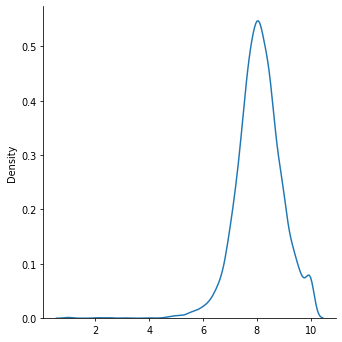

In [178]:
data = rating_df[rating_df.rating != -1].groupby('user_id').rating.mean().values
sns.displot(data, kind="kde")
plt.show()

* распределение средних рейтингов по аниме

In [179]:
rating_df[rating_df.rating != -1].groupby('anime_id').rating.mean()
# unique anime - mean ratings for anime

anime_id
1        8.752603
5        8.417238
6        8.323163
18       8.242775
20       7.712235
           ...   
32915    7.755556
32998    8.025316
33201    6.338462
33421    6.805085
33979    7.285714
Name: rating, Length: 772, dtype: float64

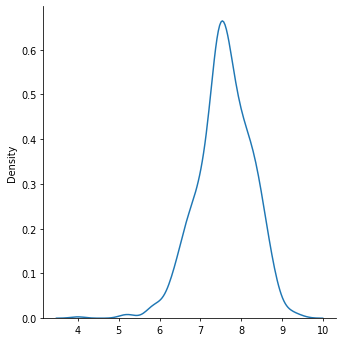

In [180]:
data = rating_df[rating_df.rating != -1].groupby('anime_id').rating.mean().values
sns.displot(data, kind="kde")
plt.show()

## Task2

In [181]:
plt.rcParams['figure.dpi'] = 150

In [13]:
users_unique = rating_df.user_id.unique()
anime_unique = rating_df.anime_id.unique()

users_id_index_map = { id: index for index, id in enumerate(users_unique) }
anime_id_index_map = { id: index for index, id in enumerate(anime_unique) }

users_dim = users_unique.size
anime_dim = anime_unique.size

rating_matrix = np.zeros((users_dim, anime_dim))

for iteraction in rating_df.iterrows():
    index, iteraction = iteraction
    user_id  = users_id_index_map[iteraction.user_id]
    anime_id = anime_id_index_map[iteraction.anime_id]
    rating   = iteraction.rating

    rating_matrix[user_id, anime_id] = rating

rating_matrix.shape

(6474, 772)

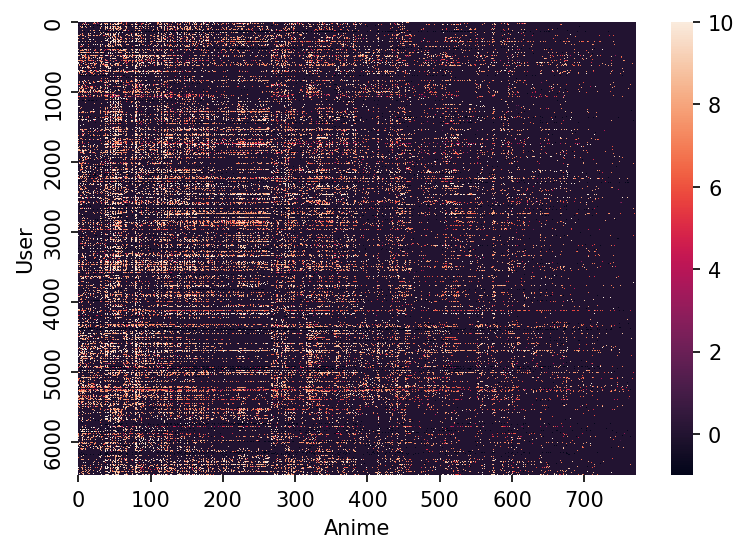

In [182]:
s = sns.heatmap(rating_matrix, xticklabels=100, yticklabels=1000)
s.set(xlabel='Anime', ylabel='User')
plt.show()

In [183]:
plt.rcParams['figure.dpi'] = 70

### Sparsity

In [184]:
numerator   = np.count_nonzero(rating_matrix)
denominator = users_dim * anime_dim
sparsity    = (1.0 - ((numerator * 1.0) / denominator)) * 100
print(f"Sparsity of rating matrix:\n{'%.2f' % sparsity}% empty")

Sparsity of rating matrix:
85.20% empty


## Task3 - Split

Для разделения на Train и Test, я выберу часть оценок пользователя  
и сохраню их как "будущие" - те, которые нужно будет предсказать

In [96]:
rating_matrix_train = rating_matrix.copy()
likeness_threshold = 7
sample_size = 5
test_values = []
for user_i in range(rating_matrix_train.shape[0]):
    test_sample = (rating_matrix_train[user_i] > likeness_threshold).nonzero()[0]
    test_sample = random.sample(list(test_sample), k=(sample_size if sample_size <= len(test_sample) else len(test_sample)))
    test_values.append(test_sample)
    for anime_i in test_sample:
        rating_matrix_train[user_i][anime_i] = 0

len(test_values)

6474

## Task 4 - Popular

In [101]:
rating_matrix_train.shape

(6474, 772)

In [102]:
rating_popularity = np.count_nonzero(rating_matrix_train, axis=0)
rating_highness   = rating_matrix_train.sum(axis=0) / rating_popularity
rating_popularity.shape, rating_highness.shape

((772,), (772,))

Самые популярные по количеству взаимодействий:

In [103]:
n = 5
rec_popular_by_iteraction_indexes = sorted(range(len(rating_popularity)), key=lambda k: rating_popularity[k])
rec_popular_by_iteraction = [anime_unique[i] for i in rec_popular_by_iteraction_indexes]
rec_popular_by_iteraction[:n]

[6481, 2429, 33979, 1404, 8111]

In [124]:
rec_popular_by_iteraction_indexes[:n]

[771, 766, 770, 759, 474]

Самые лучшие по средней оценке:

In [104]:
n = 5
rec_best_by_rating_indexes = sorted(range(len(rating_highness)), key=lambda k: rating_highness[k])
rec_best_by_rating = [anime_unique[i] for i in rec_best_by_rating_indexes]
rec_best_by_rating[:n]

[6481, 2429, 1404, 10799, 2447]

In [125]:
rec_best_by_rating_indexes[:n]

[771, 766, 759, 765, 752]

Как можно видеть - в обоих способах на первом месте одно и то же аниме

## Task 5 - SVD

In [105]:
k = 10

U, d, V = np.linalg.svd(rating_matrix_train)

U = U[:, :k]
D = np.diag(d)[:k, :k]
V = V[:k, :]

In [106]:
U.shape

(6474, 10)

In [107]:
V.shape

(10, 772)

In [108]:
u_v = U @ V
u_v.shape

(6474, 772)

Для рекомендаций возьмем только те аниме, что не смотрели

In [109]:
u_v_new = u_v * (rating_matrix_train == 0)
u_v_new

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         2.44813380e-05,  7.67536601e-06, -3.69997302e-06],
       [ 0.00000000e+00,  0.00000000e+00,  1.01840611e-03, ...,
        -8.94249747e-05, -4.00458292e-05, -7.92217327e-07],
       [ 0.00000000e+00,  3.63039766e-03, -1.19718104e-04, ...,
         9.01429495e-06,  9.52037063e-06, -6.04524721e-06],
       ...,
       [ 0.00000000e+00,  1.91497227e-03,  0.00000000e+00, ...,
         1.88641937e-05, -1.55949597e-05, -7.97554685e-07],
       [ 5.69537744e-04, -2.58001873e-04, -2.28733850e-03, ...,
         3.84523940e-05,  1.24329252e-06,  2.86696003e-06],
       [ 0.00000000e+00,  0.00000000e+00,  1.91930240e-03, ...,
         6.05888906e-06, -1.24007745e-05, -3.06672254e-06]])

Порекомендуем 5 аниме с наибольшим скором у каждого юзера

In [126]:
rec_best_by_svd_indexes = np.argpartition(u_v_new, -5, axis=1)[:, -5:]
rec_best_by_svd_indexes

array([[402,  86,  80,  67,   8],
       [312, 352, 300, 142, 268],
       [ 64,  86,  52,  27,  53],
       ...,
       [ 68,  94,  81, 275,  38],
       [163,  49, 342, 120,  50],
       [442,  76,  85,  18,   8]])

## Task 6 - Content Base

Выберем у юзера самое понравившееся ему аниме и найдем похожие по фактор-вектору из матрцы V, получившейся после SVD

In [150]:
n = 5
recs = []
for user_i in range(rating_matrix_train.shape[0]):
    best_index = np.where(rating_matrix_train[user_i] == rating_matrix_train[user_i].max())[0][0]
    mse = ((V.T - V.T[best_index])**2).mean(axis=1)
    rec = mse.argsort()[1:1 + n]
    recs.append(rec)
rec_best_by_content_indexes = np.array(recs)
print(rec_best_by_content_indexes.shape)
rec_best_by_content_indexes

(6474, 5)


array([[ 18,  22,   8,  21,  27],
       [ 38, 104,  75,  40, 111],
       [ 91,   1,  85, 100, 271],
       ...,
       [318, 430, 401,  82, 676],
       [323, 400, 439,  88, 486],
       [287, 375,   6,  49,  85]])

## Task 7 - Metrcis

### MAP@5

In [152]:
def mapk(actual, predicted):
    def ap(actual, predicted):
        score = 0.0
        num_hits = 0.0

        for i,p in enumerate(predicted):

            if p in actual:    
                num_hits += 1.0
                score += num_hits / (i+1.0)

        if num_hits != 0:

            return score / num_hits 
        else:
            return 0
    
    scores = []
    for a,p in zip(actual, predicted):
        if len(a) < len(p):
            continue
        scores.append(ap(a, p))
    return np.mean(scores)

### Popular

In [164]:
predicted = np.stack([rec_popular_by_iteraction_indexes[:5]] * len(test_values))
mapk(test_values, predicted)

8.555783709787816e-05

In [165]:
predicted = np.stack([rec_best_by_rating_indexes[:5]] * len(test_values))
mapk(test_values, predicted)

8.555783709787816e-05

### SVD

In [166]:
mapk(test_values, rec_best_by_svd_indexes)

0.2868735265039166

### Content Base

In [167]:
mapk(test_values, rec_best_by_content_indexes)

0.10229057342763707